# Simple chatbot with tools

We follow the [langgraph tutorial](https://langchain-ai.github.io/langgraph/tutorials/introduction/) to learn the basics by building a simple chatbot that can use simple tools.

## Get an LLM

To build a chatbot, we will need to use an LLM.
We follow the same steps as in the previous notebook.

In [ ]:
from typing import Annotated

from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

load_dotenv()
llm = init_chat_model(model="anthropic:claude-3-5-sonnet-latest")

# Define the state

The state of the chatbot will be the message history in the conversation, just like in the simple chatbot we built before.

In [ ]:
class State(TypedDict):
    # The state contains the message history: a list that we change with the add_messages function
    # New messages are appended to the list, rather than replacing the previous ones.
    messages: Annotated[list, add_messages]

## Create the tool

We will use the [tavily search engine](https://python.langchain.com/docs/integrations/tools/tavily_search/) tool.
This will require installing the `langchain-tavily` package and getting an API key from their [search API](https://tavily.com).
They provide a plan with free monthly credits for researchers that does not require credit card, so it's great to learn! :D
The key will need to be stored as the environment variable `TAVILY_API_KEY` in the `.env` file together with the Anthropic API key.
These environment variables are loaded in the first cell of this notebook, so run it again in case you need to.

Let's define and test the tool.

In [ ]:
from langchain_tavily import TavilySearch

tool_search = TavilySearch(max_results=2)
tool_search.invoke("What is the average weight of a red panda?")

{'query': 'What is the average weight of a red panda?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://redpandanetwork.org/red-panda-facts',
   'title': 'Red Panda Facts',
   'content': '... red pandas averages 56 to 63 cm (22 to 25 in), and their tails about 37 to 47 cm (15 to 19 in). Female Ailurus fulgens fulgens weigh 3-4.5 kg ( 6-10 lbs) on',
   'score': 0.9100432,
   'raw_content': None},
  {'url': 'https://en.wikipedia.org/wiki/Red_panda',
   'title': 'Red panda - Wikipedia',
   'content': 'The author of the study considered the red panda to be more closely related to bears.[11] A 1995 mitochondrial DNA analysis revealed that the red panda has close affinities with procyonids.[15] Further genetic studies in 2005, 2018 and 2021 have placed the red panda within the clade Musteloidea, which also includes Procyonidae, Mustelidae (weasels and relatives) and Mephitidae (skunks and relatives).[16][17][18] The tooth shows both ancestral and n

The tool provides webpage summaries that can be used then to address the tasks that we may give our agents.

## Build the chatbot

Besides defining the graph, we need to provide the LLM with the tools that will be used.
Additionally, we will need to make a new node to use the tool.

In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition  # noqa: E402

llm_with_tools = llm.bind_tools([tool_search])  # Provide the list of available tools


# Define the main nodes
def chatbot(state: State) -> State:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


tool_node_search = ToolNode([tool_search])

With the tools and the nodes defined, we can now build the graph.
In this case, we will need to use a _conditional edge_ that will connect the chatbot node to the tool use or the end depending on the state.
To keep it simple, we will use the prebuilt `tools_condition` function that will do exactly that.

In general, we are not strictly constrained to condition only between tools and end.
We can add conditional edges between any arbitrary nodes!

In [ ]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node_search)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)  # Route to tools or END
graph_builder.add_edge("tools", "chatbot")

graph = graph_builder.compile()

Let's see how the graph looks like!

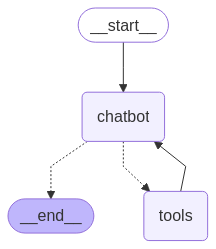

In [ ]:
# Visualize the graph
from IPython.display import Image, display  # noqa: E402

display(Image(graph.get_graph().draw_mermaid_png()))

In this system, the agent receives an input and it can either respond immediately or call a tool before doing so.

## Running the 

Let's have a conversation!

In [ ]:
def stream_graph_updates(user_input: str):
    print("User:", user_input)
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
    print("\n")


while True:
    user_input = input("User: ")
    # Terminate the conversation with quit, exit or q
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    stream_graph_updates(user_input)

User: Can you tell me what were the changes introduced in the latest langgraph release?
Assistant: [{'text': "I'll search for information about the latest langgraph release and its changes.", 'type': 'text'}, {'id': 'toolu_01KxFq74PEd7SgUbQjrGmurV', 'input': {'query': 'latest langgraph release changes github changelog', 'time_range': 'week'}, 'name': 'tavily_search', 'type': 'tool_use'}]
Assistant: {"query": "latest langgraph release changes github changelog", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "langgraph-server · GitHub Topics · GitHub", "url": "https://github.com/topics/langgraph-server", "content": "GitHub is where people build software. More than 150 million people use GitHub to discover, fork, and contribute to over 420 million projects. ... Manage code changes Discussions. Collaborate outside of code Code Search. Find more, search less ... 🚀LangGraph Deployment Kit is a framework for building, deploying, and running LangGraph-based", 

Works great! We can see here the LLM performed a few internet searches before providing the response to the user.

As a side note, our chatbot currently operates in a single-shot fashion where every user input is effectively a new conversation.
This is evidenced in the conversation above, where after thanking the chatbot it replied by admitting this was the first message in the conversation and had no idea what we were talking about before.
Typically, the user wants to have a few interactions and go back and forth with the chatbot.
We will see how to preserve context in the following notebook.